# Load parameteres with traces from CSV and calculate their features

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
# from utils import calc_features_step, calc_ramp_sum_stats, find_spikes
from utils import calc_features_ramp, calc_features_step, find_spikes

In [3]:
from dap import DAPcython
from dap.utils import obs_params, load_current
from tqdm import tqdm
from scipy.spatial import distance

In [4]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [5]:
# load the file
directory = './parameters/'
dir = glob.glob(directory + '*')

In [6]:
fname_start = dir[0].find('dap_')
fname_stop = dir[0].find('n_')
fname = dir[0][fname_start:fname_stop] + '.csv'

In [7]:
df_param = pd.read_csv(fname)
df_param.head()

,Unnamed: 0,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
0,1x14,17.173732,1.074666,131.422942,3.410514
1,1x35,17.097219,1.039869,117.684230,3.737484
2,1x9,19.007380,0.991425,95.365731,2.976070
3,1x19,16.370543,1.028504,141.774573,3.430032
4,1x24,15.153335,1.100184,163.721094,3.055541


In [8]:
df_param.set_index('Unnamed: 0', inplace=True)
df_param.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
Unnamed: 0,,,,
1x14,17.173732,1.074666,131.422942,3.410514
1x35,17.097219,1.039869,117.684230,3.737484
1x9,19.007380,0.991425,95.365731,2.976070
1x19,16.370543,1.028504,141.774573,3.430032
1x24,15.153335,1.100184,163.721094,3.055541


In [9]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

## Get Traces for each param set

In [10]:
U_steps, U_ramps = [], []

In [11]:
for i, j in tqdm(df_param.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    dap = DAPcython(-75, j)

    # run model
    U_step_x = dap.simulate(dts, ts, Is)
    U_ramp_x = dap.simulate(dtr, tr, Ir)

    # run model
    U_steps.append(U_step_x.transpose()[0])
    U_ramps.append(U_ramp_x.transpose()[0])

    # calculate distance for both currents
    dis_step = distance.euclidean(vs, U_step_x)
    dis_ramp = distance.euclidean(vr, U_ramp_x)

    # save into new columns
    df_param.loc[i, 'distance_ramp'] = dis_ramp
    df_param.loc[i, 'distance_step'] = dis_step
    df_param.loc[i, 'distance_sum'] = dis_ramp + dis_step

34it [00:38,  1.00s/it]


In [12]:
df_param.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum
Unnamed: 0,,,,,,,
1x14,17.173732,1.074666,131.422942,3.410514,909.602788,2784.920691,3694.523478
1x35,17.097219,1.039869,117.684230,3.737484,449.747855,1656.035134,2105.782990
1x9,19.007380,0.991425,95.365731,2.976070,4071.577275,5105.408817,9176.986092
1x19,16.370543,1.028504,141.774573,3.430032,568.217225,2564.059938,3132.277163
1x24,15.153335,1.100184,163.721094,3.055541,627.599487,2968.009878,3595.609366


In [13]:
df_step = pd.DataFrame({'step_traces': U_steps})
df_step.set_index(df_param.index.values, inplace=True)
df_step.head()

,step_traces
1x14,"[-75.00755278862061, -74.93943366008034, -74.9..."
1x35,"[-75.01016133862582, -74.99311860237235, -74.9..."
1x9,"[-74.99725069888777, -74.8744725466345, -74.74..."
1x19,"[-75.02127041637576, -74.9754909817063, -74.99..."
1x24,"[-75.00818734082428, -74.98248734008254, -74.9..."


In [14]:
df_ramp = pd.DataFrame({'ramp_traces': U_ramps})
df_ramp.set_index(df_param.index.values, inplace=True)
df_ramp.head()

,ramp_traces
1x14,"[-74.99104441358128, -74.96717381666272, -74.9..."
1x35,"[-74.9964730265148, -74.99344949352047, -75.00..."
1x9,"[-74.98442155386637, -74.99619227541302, -74.9..."
1x19,"[-75.01252435002492, -75.01147939082486, -75.0..."
1x24,"[-74.9914040708169, -75.01094392636297, -74.99..."


In [15]:
result = pd.merge(
    df_param,
    df_step,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN
)

result.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces
Unnamed: 0,,,,,,,,
1x14,17.173732,1.074666,131.422942,3.410514,909.602788,2784.920691,3694.523478,"[-75.00755278862061, -74.93943366008034, -74.9..."
1x35,17.097219,1.039869,117.684230,3.737484,449.747855,1656.035134,2105.782990,"[-75.01016133862582, -74.99311860237235, -74.9..."
1x9,19.007380,0.991425,95.365731,2.976070,4071.577275,5105.408817,9176.986092,"[-74.99725069888777, -74.8744725466345, -74.74..."
1x19,16.370543,1.028504,141.774573,3.430032,568.217225,2564.059938,3132.277163,"[-75.02127041637576, -74.9754909817063, -74.99..."
1x24,15.153335,1.100184,163.721094,3.055541,627.599487,2968.009878,3595.609366,"[-75.00818734082428, -74.98248734008254, -74.9..."


In [16]:
df_traces = pd.merge(
    result,
    df_ramp,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN
)

df_traces.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
Unnamed: 0,,,,,,,,,
1x14,17.173732,1.074666,131.422942,3.410514,909.602788,2784.920691,3694.523478,"[-75.00755278862061, -74.93943366008034, -74.9...","[-74.99104441358128, -74.96717381666272, -74.9..."
1x35,17.097219,1.039869,117.684230,3.737484,449.747855,1656.035134,2105.782990,"[-75.01016133862582, -74.99311860237235, -74.9...","[-74.9964730265148, -74.99344949352047, -75.00..."
1x9,19.007380,0.991425,95.365731,2.976070,4071.577275,5105.408817,9176.986092,"[-74.99725069888777, -74.8744725466345, -74.74...","[-74.98442155386637, -74.99619227541302, -74.9..."
1x19,16.370543,1.028504,141.774573,3.430032,568.217225,2564.059938,3132.277163,"[-75.02127041637576, -74.9754909817063, -74.99...","[-75.01252435002492, -75.01147939082486, -75.0..."
1x24,15.153335,1.100184,163.721094,3.055541,627.599487,2968.009878,3595.609366,"[-75.00818734082428, -74.98248734008254, -74.9...","[-74.9914040708169, -75.01094392636297, -74.99..."


## Calculate Statistics for Ramp and Step currents

In [17]:
stats_step = []

for i,u in enumerate(U_steps):
    stats = calc_features_step(u, ts, dts, t_ons, t_offs)
    stats_step.append(stats)

/home/alteska/Desktop/LFI_DAP/DAP_analysis/param_analysis/utils.py:54: RuntimeWarning: Mean of empty slice.
  ISI.mean(),
/home/alteska/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alteska/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alteska/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/alteska/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
stats_ramp = []

for i,u in enumerate(U_ramps):
    stats = calc_features_ramp(u, tr, dtr, t_onr, t_offr)
    stats_ramp.append(stats)

In [19]:
stats_step[2]

array([-49.60486185101348, 23.285821617079964, 144.0, 6.904225352112677,
       0.02619869751793899, 72,
       array([254.65, 261.7 , 268.6 , 275.55, 282.45, 289.35, 296.25, 303.15,
       310.05, 316.95, 323.85, 330.75, 337.65, 344.55, 351.45, 358.35,
       365.25, 372.15, 379.05, 385.95, 392.85, 399.75, 406.65, 413.55,
       420.45, 427.35, 434.25, 441.2 , 448.05, 455.  , 461.9 , 468.8 ,
       475.7 , 482.6 , 489.5 , 496.4 , 503.3 , 510.2 , 517.15, 524.05,
       530.95, 537.8 , 544.7 , 551.65, 558.55, 565.45, 572.35, 579.25,
       586.15, 593.05, 599.95, 606.85, 613.75, 620.65, 627.55, 634.45,
       641.4 , 648.3 , 655.2 , 662.05, 669.  , 675.9 , 682.8 , 689.7 ,
       696.6 , 703.5 , 710.4 , 717.3 , 724.15, 731.05, 737.95, 744.85])],
      dtype=object)

In [20]:
stats_ramp[0]

array([-7.37950894e+01,  1.29148403e+02,  7.30000000e-01, -6.32435117e+01,
        1.04972956e+01,  4.15800000e+01, -5.42820681e-02,  2.16000000e+00,
       -7.49910444e+01])

### Create DataFrames based on Statistics

In [21]:
step_features_labels = ['rest_pot', 'rest_pot_std','firing_rate', 'ISI_mean', 'ISI_std', 'spike_count', 'spike_times_stim']
ramp_features_labels = ['rest_pot', 'AP_amp', 'AP_width', 'fAHP', 'DAP_amp', 'DAP_width', 'DAP_deflection','DAP_time', 'mAHP']

In [22]:
df_steps = pd.DataFrame(data=stats_step, columns=step_features_labels, index=df_param.index)
df_steps.head()

,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,spike_times_stim
Unnamed: 0,,,,,,,
1x14,-69.140770,0.068418,82.0,12.260000,1.992712,41,"[252.25000000000003, 252.35000000000002, 262.3..."
1x35,-74.266505,0.027189,2.0,NaN,NaN,1,[253.75000000000003]
1x9,-49.604862,23.285822,144.0,6.904225,0.026199,72,"[254.64999999999998, 261.7, 268.6, 275.55, 282..."
1x19,-73.986726,0.031893,86.0,11.577381,6.880279,43,"[253.14999999999998, 253.25000000000003, 264.1..."
1x24,-74.851849,0.034725,168.0,5.939157,4.927413,84,"[253.0, 253.1, 256.20000000000005, 264.75, 274..."


In [23]:
df_ramps = pd.DataFrame(data=stats_ramp, columns=ramp_features_labels, index=df_param.index)
df_ramps.head()

,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP
Unnamed: 0,,,,,,,,,
1x14,-73.795089,129.148403,0.73,-63.243512,10.497296,41.58,-0.054282,2.16,-74.991044
1x35,-74.657431,129.211009,0.72,-65.153336,9.204286,17.01,-0.299809,2.11,-77.554473
1x9,-70.124956,123.240552,144.24,-58.723493,11.229595,7.69,-0.171867,2.13,-74.996192
1x19,-74.562681,130.318543,0.74,-64.613295,9.783214,21.99,-0.166172,2.25,-76.884177
1x24,-74.906630,131.498905,0.77,-64.799864,10.050512,28.16,-0.056254,2.56,-77.359302


### Save to HDF
Test behaviour when you save an array inside a cell with hdf. (Does not work well with csv).

In [24]:
df_steps.to_hdf('test.hdf', key='step_features')
df_ramps.to_hdf('test.hdf', key='ramp_features')
df_traces.to_hdf('test.hdf', key='param_traces')

/home/alteska/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['spike_times_stim']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/home/alteska/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['step_traces', 'ramp_traces']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [25]:
load_ramps = pd.read_hdf('test.hdf', key='ramp_features')
load_ramps.head()

,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP
Unnamed: 0,,,,,,,,,
1x14,-73.795089,129.148403,0.73,-63.243512,10.497296,41.58,-0.054282,2.16,-74.991044
1x35,-74.657431,129.211009,0.72,-65.153336,9.204286,17.01,-0.299809,2.11,-77.554473
1x9,-70.124956,123.240552,144.24,-58.723493,11.229595,7.69,-0.171867,2.13,-74.996192
1x19,-74.562681,130.318543,0.74,-64.613295,9.783214,21.99,-0.166172,2.25,-76.884177
1x24,-74.906630,131.498905,0.77,-64.799864,10.050512,28.16,-0.056254,2.56,-77.359302


In [26]:
load_steps = pd.read_hdf('test.hdf', key='step_features')
load_steps.head()

,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,spike_times_stim
Unnamed: 0,,,,,,,
1x14,-69.140770,0.068418,82.0,12.260000,1.992712,41,"[252.25000000000003, 252.35000000000002, 262.3..."
1x35,-74.266505,0.027189,2.0,NaN,NaN,1,[253.75000000000003]
1x9,-49.604862,23.285822,144.0,6.904225,0.026199,72,"[254.64999999999998, 261.7, 268.6, 275.55, 282..."
1x19,-73.986726,0.031893,86.0,11.577381,6.880279,43,"[253.14999999999998, 253.25000000000003, 264.1..."
1x24,-74.851849,0.034725,168.0,5.939157,4.927413,84,"[253.0, 253.1, 256.20000000000005, 264.75, 274..."


In [27]:
load_steps.spike_times_stim['1x14']

array([252.25, 252.35, 262.35, 274.45, 286.95, 299.55, 312.15, 324.7 ,
       337.3 , 350.  , 362.6 , 375.25, 387.95, 400.6 , 413.2 , 425.85,
       438.55, 451.2 , 463.95, 476.6 , 489.3 , 501.95, 514.6 , 527.3 ,
       539.9 , 552.5 , 565.2 , 577.9 , 590.6 , 603.25, 615.95, 628.6 ,
       641.25, 653.9 , 666.6 , 679.25, 691.95, 704.6 , 717.25, 729.95,
       742.65])

In [28]:
load_traces = pd.read_hdf('test.hdf', key='param_traces')
load_traces.head()


,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
Unnamed: 0,,,,,,,,,
1x14,17.173732,1.074666,131.422942,3.410514,909.602788,2784.920691,3694.523478,"[-75.00755278862061, -74.93943366008034, -74.9...","[-74.99104441358128, -74.96717381666272, -74.9..."
1x35,17.097219,1.039869,117.684230,3.737484,449.747855,1656.035134,2105.782990,"[-75.01016133862582, -74.99311860237235, -74.9...","[-74.9964730265148, -74.99344949352047, -75.00..."
1x9,19.007380,0.991425,95.365731,2.976070,4071.577275,5105.408817,9176.986092,"[-74.99725069888777, -74.8744725466345, -74.74...","[-74.98442155386637, -74.99619227541302, -74.9..."
1x19,16.370543,1.028504,141.774573,3.430032,568.217225,2564.059938,3132.277163,"[-75.02127041637576, -74.9754909817063, -74.99...","[-75.01252435002492, -75.01147939082486, -75.0..."
1x24,15.153335,1.100184,163.721094,3.055541,627.599487,2968.009878,3595.609366,"[-75.00818734082428, -74.98248734008254, -74.9...","[-74.9914040708169, -75.01094392636297, -74.99..."


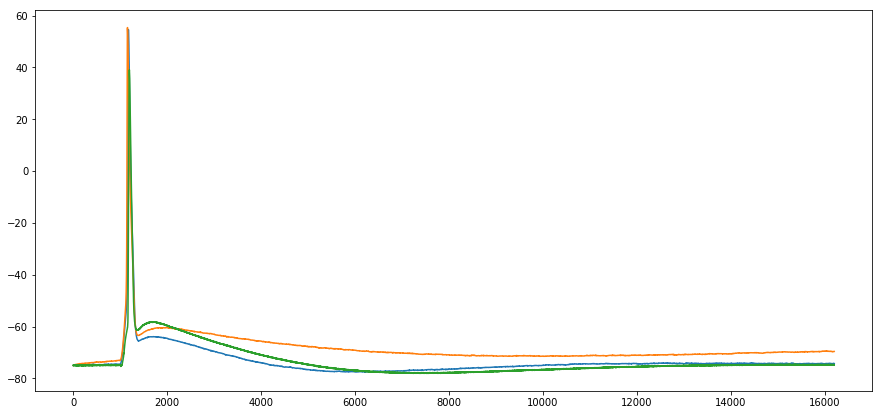

In [38]:
plt.figure(figsize=(15,7))
plt.plot(load_traces.ramp_traces['1x35'])
plt.plot(load_traces.ramp_traces['1x14'])
plt.plot(vr);

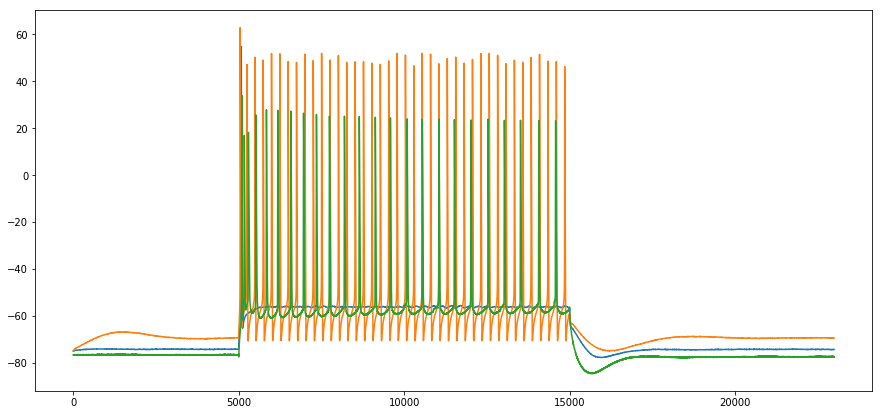

In [41]:
plt.figure(figsize=(15,7))
plt.plot(load_traces.step_traces['1x35'])
plt.plot(load_traces.step_traces['1x14'])
plt.plot(vs);